
This notebook provides the **minimal** implementation of "EmerDiff: Emerging Pixel-level Semantic Knowledge in Diffusion Models". **We are currently working on improving the notebook.** For more details, check out our project page: https://kmcode1.github.io/Projects/EmerDiff/

# Set up environment

In [ ]:
!pip install diffusers

In [ ]:
%matplotlib inline
import torch
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import torch
from math import sqrt
import torchvision
import torch.nn.functional as F
from diffusers import DDPMScheduler, DDIMScheduler, StableDiffusionPipeline, AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from collections import defaultdict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
#DDPM-inversion
#Code mostly copied from: https://github.com/inbarhub/DDPM_inversion/blob/main/ddm_inversion/inversion_utils.py
#Reference paper: https://arxiv.org/pdf/2304.06140.pdf

def add_noise(scheduler, original_samples, next_timestep, rng): #add noise from prev_timestep -> next_timestep
    noise = torch.randn(original_samples.shape, generator=rng).to("cuda")

    prev_timestep = next_timestep - scheduler.config.num_train_timesteps // scheduler.num_inference_steps
    alpha_prod_t_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.final_alpha_cumprod
    alpha_prod_t_next = scheduler.alphas_cumprod[next_timestep]

    alpha = alpha_prod_t_next / alpha_prod_t_prev
    alpha = alpha.to("cuda")

    #ref: https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py#L477
    sqrt_alpha_prod = alpha ** 0.5
    sqrt_alpha_prod = sqrt_alpha_prod.flatten()
    while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
        sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

    sqrt_one_minus_alpha_prod = (1 - alpha) ** 0.5
    sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
    while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

    noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise #x_{prev} -> x_{next}
    return noisy_samples

def sample_xts_from_x0(unet, scheduler, x0, num_inference_steps, rng):
    alpha_bar = scheduler.alphas_cumprod
    sqrt_one_minus_alpha_bar = (1-alpha_bar) ** 0.5
    variance_noise_shape = (
            num_inference_steps,
            x0.shape[-3],
            x0.shape[-2],
            x0.shape[-1])

    timesteps = scheduler.timesteps.to("cuda")
    t_to_idx = {int(v):k for k,v in enumerate(timesteps)}
    xts = torch.zeros(variance_noise_shape).to(x0.device)
    for t in reversed(timesteps):
        idx = t_to_idx[int(t)]
        xts[idx] = x0 * (alpha_bar[t] ** 0.5) + torch.randn(x0.shape, generator=rng).to("cuda") * sqrt_one_minus_alpha_bar[t]
    xts = torch.cat([xts, x0 ],dim = 0)

    return xts

def get_variance(scheduler, timestep):
    prev_timestep = timestep - scheduler.config.num_train_timesteps // scheduler.num_inference_steps
    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    alpha_prod_t_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.final_alpha_cumprod
    beta_prod_t = 1 - alpha_prod_t
    beta_prod_t_prev = 1 - alpha_prod_t_prev
    variance = (beta_prod_t_prev / beta_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)
    return variance

def inversion_forward_process(unet, scheduler, x0,
                              uncond_embedding,
                              etas = 1.0,
                              num_inference_steps=50,
                              ddpm_seed = 40
                             ):

    timesteps = scheduler.timesteps.to("cuda")
    variance_noise_shape = (
        num_inference_steps,
        x0.shape[-3],
        x0.shape[-2],
        x0.shape[-1])
    rng = torch.Generator().manual_seed(ddpm_seed)

    etas = [etas]*scheduler.num_inference_steps
    #generate noisy samples xts
    xts = sample_xts_from_x0(unet, scheduler, x0, num_inference_steps=num_inference_steps, rng = rng)
    alpha_bar = scheduler.alphas_cumprod
    zs = torch.zeros(size=variance_noise_shape, device="cuda") #[50, 4, 64, 64]

    t_to_idx = {int(v):k for k,v in enumerate(timesteps)}
    xt = x0

    for t in timesteps:
        idx = t_to_idx[int(t)]

        xt = xts[idx][None]

        with torch.no_grad():
            out = unet.forward(xt, timestep =  t, encoder_hidden_states = uncond_embedding)

        noise_pred = out.sample

        xtm1 =  xts[idx+1][None]
        pred_original_sample = (xt - (1-alpha_bar[t])  ** 0.5 * noise_pred ) / alpha_bar[t] ** 0.5
        prev_timestep = t - scheduler.config.num_train_timesteps // scheduler.num_inference_steps
        alpha_prod_t_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.final_alpha_cumprod
        variance = get_variance(scheduler, t)
        pred_sample_direction = (1 - alpha_prod_t_prev - etas[idx] * variance ) ** (0.5) * noise_pred
        mu_xt = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction
        z = (xtm1 - mu_xt ) / ( etas[idx] * variance ** 0.5 )
        zs[idx] = z
        xtm1 = mu_xt + ( etas[idx] * variance ** 0.5 )*z
        xts[idx+1] = xtm1
    return xts, zs, timesteps

def reverse_step(scheduler, model_output, timestep, sample, eta, variance_noise):
    prev_timestep = timestep - scheduler.config.num_train_timesteps // scheduler.num_inference_steps
    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    alpha_prod_t_prev = scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.final_alpha_cumprod
    beta_prod_t = 1 - alpha_prod_t
    pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
    variance = get_variance(scheduler, timestep)
    std_dev_t = eta * variance ** (0.5)
    model_output_direction = model_output
    pred_sample_direction = (1 - alpha_prod_t_prev - eta * variance) ** (0.5) * model_output_direction
    prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction
    if eta > 0:
        sigma_z =  eta * variance ** (0.5) * variance_noise
        prev_sample = prev_sample + sigma_z

    return prev_sample

In [ ]:
#utils
def load_img(path, resize_to_512 = False):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    if resize_to_512:
      w, h = 512, 512
    else:
      fac = sqrt(512*512/w/h)
      w = int(w*fac)
      h = int(h*fac)
      w, h = map(lambda x: x - x % 64, (w + 63, h + 63))  # resize to integer multiple of 64
    image = image.resize((w, h), resample=Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2. * image - 1.

def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

In [ ]:
class Controller:
    def __init__(self, config):
        self.config = config

        self.record_mask_proposal = False #record feature maps for clustering
        self.record_attention = False #record original q/k/v
        self.use_recorded_attention = False #use recorded original attention to ensure better reconstruction
        self.perturb_feature = False #perturb feature map

        self.store = defaultdict(lambda : 0) #for mask proposal
        self.store_cnt = defaultdict(lambda : 0)
        self.orig = {} #for recording original q/k/v

        self.t = -1

        self.h = self.w = 512 #resolution of image
        self.compress_rate = config.compress_rate #resolution of image/resolution of latent

        self.lam1 = config.lam1
        self.lam2 = config.lam2

        return

    def extract_mask_feature(self):
        fet = [] #[h*w,768]
        for (k, v) in self.store.items():
            fet.append(v.unsqueeze(0)/self.store_cnt[k]) #take mean
        self.store = defaultdict(lambda : 0)
        self.store_cnt = defaultdict(lambda : 0)
        fet = torch.cat(fet,dim=0) #(sample, h*w, 768)
        fet = fet.permute((1,0,2)) #(h*w, sample, 768)
        fet = fet.reshape((fet.shape[0], -1)) #(h*w, sample*768)

        return fet

    def store_attn(self, ty, pos, res, idx, query, key, val):
        if self.record_mask_proposal:
            if (ty, pos, res, idx) in self.config.record_mask_proposal_layers:
                fet = query[0].clone().detach().cpu() #[h*w, 768]
                self.store[(self.t,ty,pos,res,idx)] += fet
                self.store_cnt[(self.t,ty,pos,res,idx)] += 1
        if self.record_attention:  #save cross/self attention map
            self.orig[(self.t, ty, pos, res, idx)] = (query.detach().clone().cpu(), key.detach().clone().cpu())
        if self.use_recorded_attention: #preserve cross/self attention map
            query_, key_= self.orig[(self.t, ty, pos, res, idx)]
            query[:] = query_[0].to("cuda")
            key[:] = key_[0].to("cuda")
        return query, key, val

    def modify_feature(self, hidden_states, ty, pos, res, idx, to_v = None):
        if self.perturb_feature and ((ty, pos, res, idx) in self.config.perturb_feature_layers):
            original_shape = hidden_states.shape
            if len(original_shape) == 4: #[2, 1280, 16, 16]
                hidden_states = hidden_states.reshape((hidden_states.shape[0], hidden_states.shape[1], -1)).permute((0,2,1)) #[2,h*w,1280]
            mask = self.mask.reshape((1,-1,1)) #[1,h*w,1]
            if hidden_states.shape[0] == 2:
                lam = torch.from_numpy(np.array([self.lam1, self.lam2])).float().reshape(2,1,1).to("cuda")
            else:
                lam = torch.from_numpy(np.array([self.lam1])).float().reshape(1,1,1).to("cuda")
            hidden_states = hidden_states + lam*mask
            if len(original_shape) == 4:
                hidden_states = hidden_states.permute((0,2,1)).reshape(original_shape)
        return hidden_states

def inject_attention(unet, controller):
        def new_forward_attention(ty = "cross", pos = "up", res=0, idx = 0):
             def forward(attn, hidden_states, encoder_hidden_states=None, attention_mask=None):
                batch_size, sequence_length, _ = (
                    hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
                )
                inner_dim = hidden_states.shape[-1]
                query = attn.to_q(hidden_states) #(batch, seq_len, num_heads*head_dim)
                if encoder_hidden_states is None:
                    encoder_hidden_states = hidden_states
                key = attn.to_k(encoder_hidden_states) #(batch, seq_len, num_heads*head_dim)
                value = attn.to_v(encoder_hidden_states) #(batch, seq_len, num_heads*head_dim)
                head_dim = inner_dim // attn.heads

                #store qkv
                query, key, value = controller.store_attn(ty, pos, res, idx, query, key, value)

                query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2) #(batch, num_heads, seq_len, head_dim)
                key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
                value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

                hidden_states = F.scaled_dot_product_attention(
                    query, key, value, attn_mask=attention_mask
                )

                hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim) #(batch, seq_len, num_heads*head_dim)
                hidden_states = hidden_states.to(query.dtype)

                # linear proj
                hidden_states = attn.to_out[0](hidden_states)

                #perturb the output
                hidden_states = controller.modify_feature(hidden_states,ty, pos, res, idx, None)

                return hidden_states
             return forward
        def inject_block(blocks=unet.up_blocks, pos="up"):
            #ref: https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet_2d_condition.py
            res = -1
            if pos == "mid":
                children = [blocks]
            else:
                children = blocks.children()
            for net_ in children:
                if net_.__class__.__name__ in ["CrossAttnUpBlock2D","CrossAttnDownBlock2D","UNetMidBlock2DCrossAttn"]:
                    res += 1
                    idx = -1
                    for atn in net_.attentions:
                           if atn.__class__.__name__ == "Transformer2DModel":
                                idx += 1
                                for block in atn.transformer_blocks:
                                    if block.__class__.__name__ == "BasicTransformerBlock":
                                        #self attention
                                        if block.attn1.processor.__class__.__name__ == "AttnProcessor2_0":
                                            block.attn1.processor = new_forward_attention(ty = "self", pos = pos, res = res, idx = idx)
                                        #cross attention
                                        if block.attn2.processor.__class__.__name__ == "AttnProcessor2_0":
                                            block.attn2.processor = new_forward_attention(ty="cross", pos = pos, res = res, idx = idx)
        inject_block(unet.up_blocks, pos="up")
        inject_block(unet.down_blocks, pos="down")
        inject_block(unet.mid_block, pos="mid")

In [ ]:
class Model:
    def __init__(self, config):
        self.config = config

        #load model
        self.ddim_scheduler = DDIMScheduler().from_pretrained(config.stable_version, subfolder="scheduler", cache_dir=config.cache_dir)
        self.ddim_scheduler.set_timesteps(config.inference_steps, device="cuda")
        self.vae = AutoencoderKL.from_pretrained(config.stable_version, subfolder="vae",cache_dir=config.cache_dir).to("cuda")
        requires_grad(self.vae, False)
        self.tokenizer = CLIPTokenizer.from_pretrained(config.clip_version, cache_dir=config.cache_dir)
        self.text_encoder = CLIPTextModel.from_pretrained(config.clip_version, cache_dir=config.cache_dir).to("cuda")
        requires_grad(self.text_encoder, False)
        self.unet = UNet2DConditionModel.from_pretrained(config.stable_version, subfolder="unet", cache_dir=config.cache_dir).to("cuda")
        requires_grad(self.unet, False)

        self.uncond = self.get_text_embedding([config.uncond_words])

        #load attention controller and inject
        self.controller = Controller(config)
        inject_attention(self.unet, self.controller)

    def latent2tensor(self, latents):
        x_samples = self.vae.decode(latents / 0.18215).sample #[1,3,512,512]
        return x_samples
    def tensor2latent(self, image):
        latents = self.vae.encode(image)['latent_dist'].mean
        latents = latents * 0.18215
        return latents
    def get_text_embedding(self, prompt, device="cuda"):
        tokens = self.tokenizer(prompt, padding="max_length", max_length=self.tokenizer.model_max_length, truncation=True, return_tensors="pt")
        for i in range(1):
            text_embeddings = self.text_encoder(tokens.input_ids.to(device))[0] #[1, 77, 768]
            return text_embeddings
    def record_ddpm(self, z0, tims):
        #Add noises to z0 under the shared seed at tims and run unet
        rng = torch.Generator().manual_seed(self.config.ddpm_seed) #shared noise
        for t in tims:
            if t < 0:
                lat, t = init_latent, 0
            else:
                noise = torch.randn(z0.shape, generator=rng).to("cuda")
                zt = self.ddim_scheduler.add_noise(z0, noise=noise, timesteps = torch.tensor([t]).int())
            self.controller.t = t
            self.unet(zt, t, encoder_hidden_states = self.uncond)
    def diffusion_step(self, t, latents, cond1, cond2 = None, z_ddpm = None):
        #diffusion_step: x_t -> x_{t-1}
        if cond2 != None:
          text_embeddings  = torch.cat([cond1, cond2])
        else:
          text_embeddings = cond1
        noise_pred = self.unet(
                                latents,
                                t,
                                encoder_hidden_states=text_embeddings
                            ).sample
        z_ddpm = z_ddpm.expand(latents.shape[0],-1,-1,-1) #scheduled noise
        return reverse_step(self.ddim_scheduler, noise_pred, t, latents, 1.0, z_ddpm) #ddpm_inversion

# Config

In [ ]:
class ConfigBase:
    #Model Config
    stable_version = "CompVis/stable-diffusion-v1-4"
    clip_version = "openai/clip-vit-large-patch14"
    cache_dir = "./"
    compress_rate = 32 #(input image resolution) / (cross-attention resolution)
    vae_compress_rate = 8 #(input image resolution) / (latent resolution)

    #Method Config
    inference_steps = 50 #total inference steps

    #For mask proposal
    lam1 = -10 #negative offset
    lam2 = 10 #positive offset
    num_mask = 25 #number of segmentation masks
    k_means_seed = 1234
    uncond_words =  ''
    n_init = 100 # use "auto" in practice
    init_algo = "k-means++"
    kmeans_algo = "lloyd"
    tims_mask = [0]*100 #timesteps for mask proposal. Better to sample several times for convergence. Reduce it in practice.
    inject_offset_tims = [281] #timesteps to modulaate feature maps (i.e. inject offsets)

    #For feature extraction
    ddpm_seed = 42 #we use shared ddpm noise

    #Create palatte (todo)
    np.random.seed(123)
    palette = np.random.choice(range(256), size=(1000,3)).astype(np.uint8)

    #Layers
    record_mask_proposal_layers = [("cross", "up", 0, 0)] #(ty, pos, res, idx), layers to record feature maps
    perturb_feature_layers = [("cross", "up", 0, 2)] #layers to inject noise

# Main pipeline

In [ ]:
class MaskProposal:
    num_mask = None #number of masks
    ids_img = None #high-resolution segmentation maps: e.g. [512*512] -> mask_id
    ids_hidden = None #low-resolution segmentation maps: e.g. [16*16] -> mask_id

    def save_cluster(self, clusters, filename):
        col = self.config.palette[clusters.flatten()].reshape(clusters.shape+(3,))
        label = Image.fromarray(col).resize((self.w, self.h), Image.NEAREST)
        label.save(filename)

    def __init__(self, config, model, init_latent):

        self.config = config
        self.h = init_latent.shape[-2]*config.vae_compress_rate
        self.w = init_latent.shape[-1]*config.vae_compress_rate

        #Step 1. extract mask features maps for clustering
        model.controller.record_mask_proposal = True
        model.record_ddpm(init_latent, config.tims_mask)
        model.controller.record_mask_proposal = False

        #Step 2. cluster feature maps to produce low-resolution segmentation maps
        print("Perform K-means and generate low resolution masks..")
        mask_fet = model.controller.extract_mask_feature() #[16*16, 1280]
        kmeans = KMeans(n_clusters=config.num_mask, init=config.init_algo, n_init=config.n_init, random_state = config.k_means_seed, algorithm=config.kmeans_algo).fit(mask_fet.numpy())
        #self.save_cluster(kmeans.labels_.reshape((self.h//config.compress_rate, self.w//config.compress_rate)), "./mask_proposal.png")
        self.ids_hidden = torch.from_numpy(kmeans.labels_)

        self.num_mask = self.ids_hidden.max()+1

        #Perform DDPM inversion
        print("Perform DDPM inversion..")
        invert_until = int(max(config.inject_offset_tims)//20+1)
        xts, zs, ts = inversion_forward_process(model.unet, model.ddim_scheduler, init_latent, model.uncond, 1.0, config.inference_steps,  ddpm_seed = config.ddpm_seed)
        xts = xts.unsqueeze(1)
        xts = xts[-invert_until-1:-1] #excludes x0
        ts = ts[-invert_until:]
        zs = zs[-invert_until:]
        original_latent_t = list(zip(xts, ts))

        #Store original attention maps
        with torch.no_grad():
            model.controller.record_attention = True
            original_latents = original_latent_t[0][0]
            for i, (_, t) in enumerate(original_latent_t):
                model.controller.t = t
                original_latents = model.diffusion_step(t, original_latents, model.uncond, z_ddpm = zs[i])
            model.controller.record_attention = False

        #Step 3. Now, perform modulated diffusion process for each low-resolution mask
        print("Now generating pixel-level segmentation maps..")
        def sample_loop(latents):
            latents = torch.cat([latents]*2,dim=0)
            model.controller.use_recorded_attention = True
            with torch.no_grad():
                #Modulated denoising loop
                for i, (_, t) in enumerate(original_latent_t):
                    model.controller.t = t
                    model.controller.perturb_feature = (t in config.inject_offset_tims) #Modify attention map
                    latents = model.diffusion_step(t, latents, model.uncond, model.uncond, z_ddpm = zs[i])
            model.controller.use_recorded_attention = False
            model.controller.perturb_feature = False
            x_edited = model.latent2tensor(latents) #[2,3,512,512]
            return x_edited

        def generate_dif_map(cluster_id):
            print("Peform modulated denoising process for mask id:", cluster_id)
            model.controller.mask = (self.ids_hidden == cluster_id).float().to("cuda") #[16,16]
            x_edited = sample_loop(original_latent_t[0][0])
            x_edited = torchvision.transforms.functional.gaussian_blur(x_edited, kernel_size=3)
            dif_map = torch.linalg.norm(x_edited[0:1]-x_edited[1:2], dim=1)
            return dif_map #[1,512,512]

        lis_img = []
        for i in range(config.num_mask):
            with torch.no_grad():
                lis_img.append(generate_dif_map(i).cpu())
        self.ids_img = torch.argmax(torch.cat(lis_img,dim=0),dim=0) #[HxW]

# Load image

--2024-05-05 12:07:37--  https://raw.githubusercontent.com/NVlabs/ODISE/main/demo/examples/coco.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 266176 (260K) [image/jpeg]
Saving to: ‘coco.jpg.2’

coco.jpg.2          100%[===================>] 259.94K  --.-KB/s    in 0.004s  

2024-05-05 12:07:37 (58.8 MB/s) - ‘coco.jpg.2’ saved [266176/266176]



(-0.5, 511.5, 511.5, -0.5)

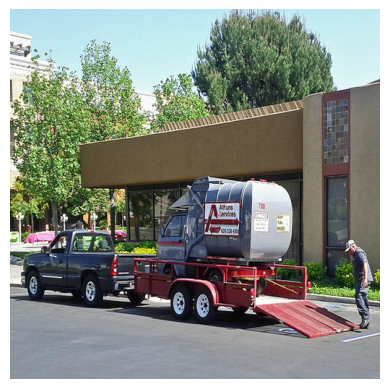

In [ ]:
!wget https://raw.githubusercontent.com/NVlabs/ODISE/main/demo/examples/coco.jpg
img = load_img(path="./coco.jpg", resize_to_512 = True).cuda()
plt.figure()
plt.imshow(((img[0]+1.0)/2.0*255.0).permute((1,2,0)).cpu().numpy().astype(np.uint8))
plt.axis('off')

# Generate segmentation masks

In [ ]:
config = ConfigBase()
model = Model(config)
init_latent = model.tensor2latent(img)
mask_proposal = MaskProposal(config, model, init_latent)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Perform K-means and generate low resolution masks..
Perform DDPM inversion..
Now generating pixel-level segmentation maps..
Peform modulated denoising process for mask id: 0
Peform modulated denoising process for mask id: 1
Peform modulated denoising process for mask id: 2
Peform modulated denoising process for mask id: 3
Peform modulated denoising process for mask id: 4
Peform modulated denoising process for mask id: 5
Peform modulated denoising process for mask id: 6
Peform modulated denoising process for mask id: 7
Peform modulated denoising process for mask id: 8
Peform modulated denoising process for mask id: 9
Peform modulated denoising process for mask id: 10
Peform modulated denoising process for mask id: 11
Peform modulated denoising process for mask id: 12
Peform modulated denoising process for mask id: 13
Peform modulated denoising process for mask id: 14
Peform modulated denoising process for mask id: 15
Peform modulated denoising process for mask id: 16
Peform modulated de

# Visualize image-level segmentation maps

(-0.5, 511.5, 511.5, -0.5)

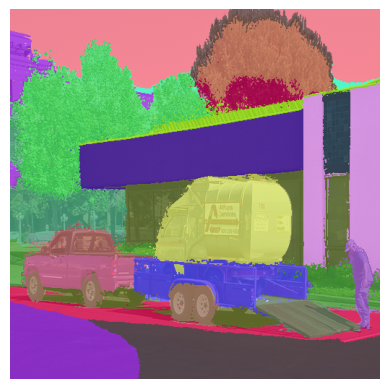

In [ ]:
#Visualize pixel-level segmentation maps
col_img = config.palette[mask_proposal.ids_img.flatten()].reshape(mask_proposal.ids_img.shape+(3,))
im = np.array(col_img)*0.8+((img[0]+1.0)/2.0*255.0).permute((1,2,0)).cpu().numpy()*0.2
plt.imshow(Image.fromarray(im.astype(np.uint8)))
plt.axis('off')